## Start running flowacc / chi calc on all basin

In [2]:
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point
#import rasterio
import geopandas as gpd
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/gr_1/Documents/simplem/')
import simplem_par as simplem
import matplotlib.pyplot as plt
#import multiprocess as mp

In [3]:
eros1 = [None]*4631
eros2 = np.zeros(4631)
slpsall = np.zeros(4631)
slps2 = np.zeros(4631)
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octopus_v2/')
a = a.to_crs('EPSG:4326')

/var/folders/5v/804c95h92bx2zr8rfpwyr_yc0000gn/T/ipykernel_1849/2467896498.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  a.geometry=a.geometry.centroid
sh: taskset: command not found


here
err: 0
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_0.tif: No such file or directory
err: 1
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_1.tif: No such file or directory
err: 2
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_2.tif: No such file or directory
err: 3
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_3.tif: No such file or directory
err: 4
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_4.tif: No such file or directory
err: 5
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_5.tif: No such file or directory
err: 6
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_6.tif: No such file or directory
err: 7
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_7.tif: No such file or directory
err: 8
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_8.tif: No such file or directory
err: 9
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_9.tif: No such file or directory
err: 10
/Users/gr_1/Documents/basins_v3/hydrosheds_bas_v3_10.tif: No such file or directory
err

KeyboardInterrupt: 

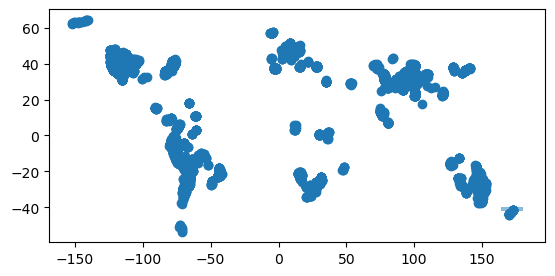

In [4]:
import multiprocess as mp
import matplotlib.pyplot as plt
import rasterio
import sys
#sys.path.insert(1, '/Users/gr_1/Documents/simplem/') #modify based on where it is
import simplem_par as simplem
import numpy as np
import ast
import os
import shapely


a.geometry=a.geometry.centroid
#bbox = (164.056143, -32, 179.9017855, -48)
bbox = (164.056143, -42, 179.9017855, -40)
polygon = shapely.geometry.box(*bbox, ccw=True)
b = gpd.GeoDataFrame([0],geometry=[polygon])
b=b.set_crs('4326')
b=b.to_crs(a.crs)
f,p=plt.subplots()
a.plot(ax=p)
b.plot(ax=p,alpha=.5)
a=a[a.within(b.iloc[0].geometry)]

os.system("taskset -p 0xff %d" % os.getpid())

################ -------Params-------- ##################################
dem_folder = '/Users/gr_1/Documents/basins_v3/'
outfolder = '/Users/gr_1/Documents/cosmo_predict_cz/results/vf_dall_{}/'.format('nz')
# Number of processors
n_proc = 6
# Number of simulations (parameter sets)
nr = 1000
## Stream power parameters
#Stream power m/n (theta)
theta = 0.45  
# Vector of n values.  Currently n ranges from 0-4
ns = np.load('../lem_global_optimimize_krakonos/ns.npy')[0:nr]#np.random.rand(nr) * 4.0 
# The ratio D/k. Currently the prior distribution is log-uniform from 0 to 10
diffus =  np.load('../lem_global_optimimize_krakonos/diffus.npy')[0:nr]*1e-11#np.power(10.0, np.random.rand(nr) * 12 + 1)  
#A_crit values range as a log-uniform distribution
careas = np.load('../lem_global_optimimize_krakonos/careas.npy')[0:nr]*0+10#np.power(10.0, np.random.rand(nr) * 3) 
# diffusion exponents (p)
ps = np.zeros(nr) + 1.0 
########################################################################


n_basin = 4631  # number of basins in octopus
ms = ns * theta # Vector of m values.  m depends on n

#The erosion rates for each basin, to contain a vector of avg erosion rates
eros1 = [None] * n_basin
#vector of avg slopes in each basin, to compare to octopus slopes
slpsall = np.zeros(n_basin)
# minrun = int(sys.argv[1])
# maxrun = int(sys.argv[2])
ksns = np.zeros(n_basin)
def par_ero(i):
    """
    Parallel erosion routine for each DEM basin
    
    :param i: basin number
    :returns: A; accumulated erosion
    """
    
    #First run diffusion - we raise the coefficient by 1/p and then raise the whole
    #diffusion rate by p in order to
    E = simplem.diffuse(
        Zi, D=-(diffus[i]**(1.0 / ps[i])), dy=dy1, dx=dx1, dt=1)
    E[E < 0] = 0
    #We only want the erosion part....
    E = E**ps[i]
    #Raise too p
    m = ms[i]
    n = ns[i]
    #Now add the hillslope erosion and the fluvial erosion
    ero = simplem.erode_explicit(
        slps,
        I1,
        s1,
        A1,
        E,
        dx=dx1,
        dy=dy1,
        m=ms[i],
        n=ns[i],
        k=np.zeros(np.shape(slps))+1e-8,
        carea=careas[i])
    
    #This should be zero anyways but just in case...
    ero[slps == 0] = 0
    ero[ero<=0]=0
    #Sum erosion downstream = we do it this way so that nodes draining outside of the basin (i.e. on the edge) are not included
    A = simplem.acc(I1, s1, init=ero.copy())
    #Calculate the avg erosion per drainage area...
    pl = (A.ravel()[np.argmax(A1.ravel())]) / np.max(A1.ravel())
    return pl, i
def smuth(windowSize,I,s,z,acc,athres=5):
    zsd = np.zeros((windowSize,len(I)))
    zsu = np.zeros((windowSize,len(I)))
    avgs=np.zeros(len(I))
    distsU=np.zeros(len(I))
    distsD = np.zeros(len(I))
    ns = np.zeros(len(I))
    amaxs = np.zeros(len(I))
    for i in range(len(I)):
        if s[i] != I[i]:
            zsd[:-1,I[i]] = zsd[1:,s[i]]
            zsd[-1,I[i]] = z[s[i]]
    for i in range(len(I)-1,0,-1):
        if s[i] != I[i]:
            if (acc[I[i]] >= windowSize) and (acc[I[i]] >= amaxs[s[i]]):
                amaxs[s[i]] = acc[I[i]]
                zsu[:,s[i]] = zsu[:,I[i]]
                zsu[:-1,s[i]] = zsu[1:,I[i]]
                zsu[-1,s[i]] = z[I[i]]
    for i in range(len(I)):
        lu = len(np.where(zsu[:,i]>0)[0])
        ld = len(np.where(zsd[:,i]>0)[0])
        minl = min([lu,ld])
        if minl>=windowSize:
            avgs[i] = np.mean(np.concatenate([zsd[:,i][zsd[:,i]>0], zsu[:,i][zsu[:,i]>0]]))
        elif minl>=1:
            avgs[i] = np.mean(np.concatenate([zsd[:,i][zsd[:,i]>0][-minl:], zsu[:,i][zsu[:,i]>0][-minl:]]))
        else:
            avgs[i] = z[i]
    return avgs
            
print('here')
for c in range(5000):
    
    try:
        try:
            dem = rasterio.open(dem_folder + 'hydrosheds_bas_v6_{}.tif'.format(str(c)))
            secs = 1
            dy = 92.59/3
            print("here")
        except:
            dem = rasterio.open(dem_folder + 'hydrosheds_bas_v3_{}.tif'.format(str(c)))
            secs=3
            dy = 92.59
        if c not in a.index[:]:
            print(c)
            continue
        print(c)
        lat = dem.xy(0, 0)[1]
        dx = np.cos(lat / 180 * np.pi) * (1852 / 60) * \
            secs  # dx is dependent on latitude
        f = simplem.simple_model()
        f.dx = dx
        f.dy = dy
        
        # We must pad the DEM in order to prevent edge effects
        demz = np.pad(np.float64(np.squeeze(dem.read())), pad_width=2)
        demz[np.logical_not(demz>0)]=0
        demzi=demz.copy()
        f.set_z(demz.copy())
        
        #Outlet nodes are at or below 0
        f.BC = np.where(f.Z.transpose().ravel() <= 0)[0]
        
        #Fill local sinks
        f.sinkfill()
        
        #calculate local slopes and populate the receiver grid
        f.slp_basin()
        
        #Build the Fastscape stack
        f.stack()
        
        #calculate the receiver grid
        f.acc()
        
        #Get Elevation, corrected
        Zi2 = f.Z.copy()
        s = f.s.ravel(order='F')[f.I].copy()
        s2 = f.s.ravel(order='F').copy()
        z=demz.ravel(order='F')
        acc=f.A.ravel(order='F')
        A=smuth(5,f.I.copy(),s.copy(),z.copy(),acc.copy(),5)
        Zi = A.reshape(np.shape(Zi2),order='F').copy()

        print(np.shape(Zi))
        #Get drainage area
        A1 = f.A.copy()
        
        #Initialize mean erosion rate (per basin) vector
        mnmat = np.zeros((len(ms), 1))
        
        
        A1 = f.A.copy()
        ny1 = f.ny
        nx1 = f.nx
        I1 = f.I.copy()
        s1 = f.s.copy()
        dy1 = f.dy
        ## Add this for smoothed DEM
        f.Z = Zi.copy()
        f.slp_basin()
        ##
        
        Zi = demz.copy()
        slps = f.slps.copy()
        dx1 = dx
        with mp.Pool(n_proc) as procs:
            vals = procs.map(par_ero, np.arange(len(ns)))
        #par_ero(1)
        eros1[c] = mnmat[list(zip(*vals))[1], 0] = list(zip(*vals))[0]
        f.Z=Zi2.copy()
        ksn2 =  slps / A1**.45 
        ksns[c] = np.mean(ksn2[f.Z>0])
        f.slp_basin()
        f.acc(slps)
        slpsall[c] = (f.A.ravel()[f.Z.ravel() > 0][np.argmax(
            A1.ravel()[f.Z.ravel() > 0])]) / np.max(A1.ravel()[f.Z.ravel() > 0])
    except Exception as e:
        print('err: ' + str(c))
        print(e)
# eros1[eros1==None]=np.nan
# io=[]
# for i in eros1:
#     try:
#         io.append(i[0])
#     except:
#         io.append(i)
np.save('{}/eros'.format(outfolder),eros1,allow_pickle=True)
np.save('{}/diffu'.format(outfolder),np.float64(diffus))
np.save('{}/ms'.format(outfolder),np.squeeze(ms))
np.save('{}/ns'.format(outfolder),np.squeeze(ns))
np.save('{}/careas'.format(outfolder),np.squeeze(careas))
np.save('{}/slps2'.format(outfolder),np.squeeze(slpsall))
np.save('{}/dns'.format(outfolder),np.squeeze(ps))
np.save('{}/ksns'.format(outfolder),np.squeeze(ksns))


In [16]:
np.sort(f.A.ravel())

array([1.000000e+00, 1.000000e+00, 1.000000e+00, ..., 2.751501e+06,
       2.751515e+06, 2.751517e+06])

In [1]:
np.save('{}/eros'.format(outfolder),eros1,allow_pickle=True)
np.save('{}/diffu'.format(outfolder),np.float64(diffus))
np.save('{}/ms'.format(outfolder),np.squeeze(ms))
np.save('{}/ns'.format(outfolder),np.squeeze(ns))
np.save('{}/careas'.format(outfolder),np.squeeze(careas))
np.save('{}/slps2'.format(outfolder),np.squeeze(slpsall))
np.save('{}/dns'.format(outfolder),np.squeeze(ps))

NameError: name 'np' is not defined

In [4]:
eros2 = eros1
for c in range(0,4900,1):
    eros2

NameError: name 'eros1' is not defined

In [121]:
np.max(vals[1][2])

NameError: name 'vals' is not defined

In [122]:
plt.imshow(vals[1][2])

NameError: name 'vals' is not defined

In [123]:
careas[1]

107.46261880726735

In [124]:
plt.plot(a['SLP_AVE'])
plt.ylim([0,100])

KeyError: 'SLP_AVE'

KeyError: 'SLP_AVE'

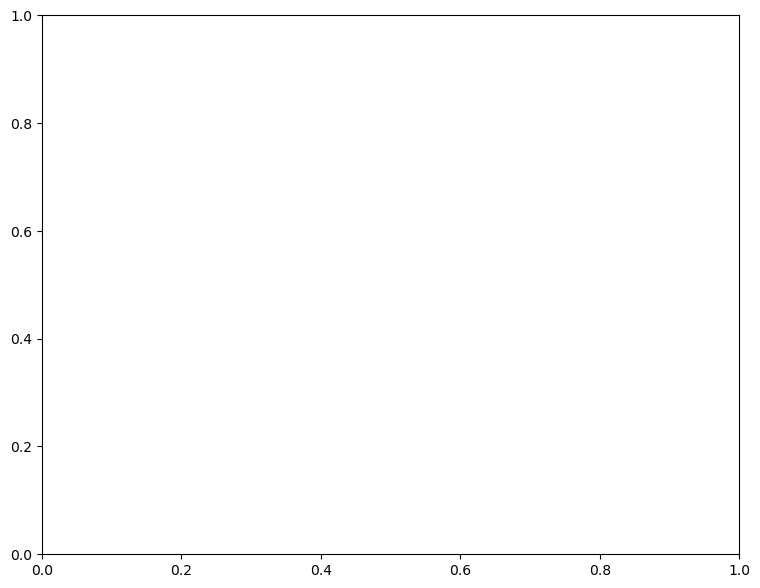

In [125]:
fig,ax = plt.subplots(figsize=(9,7))

plt.plot(slps2[:len(a)],a['SLP_AVE']/1000,'k.')
plt.plot(slps2,slps2,'.')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('D8 slope (m/m)')
plt.ylabel('Avg surface slope (m/m)')
plt.xlim([10**-3, 10**0])
plt.ylim([10**-3, 10**0])

/var/folders/5v/804c95h92bx2zr8rfpwyr_yc0000gn/T/ipykernel_2067/1767807917.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


Text(0, 0.5, 'Observed erosion rate (mm/kyr)')

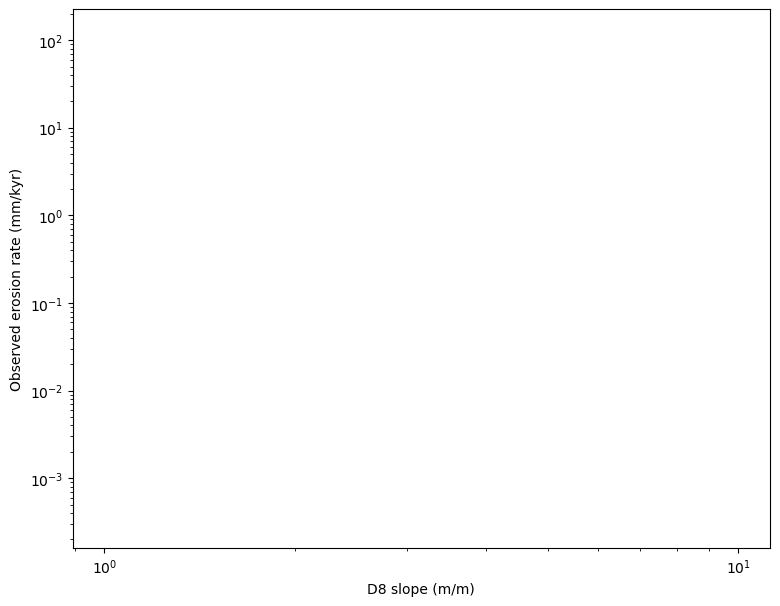

In [126]:
fig,ax = plt.subplots(figsize=(9,7))
plt.plot(slpsall[:len(a)],a['ebe_mmkyr']/1000,'k.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('D8 slope (m/m)')
plt.ylabel('Observed erosion rate (mm/kyr)')

In [127]:
plt.plot(np.log10(ks2),r2s,'.')
ro = np.where(r2s>.01)[0][5]
plt.plot(dfs[ro][:len(a)],a['ebe_mmkyr'], '.')
plt.xscale('log')
plt.yscale('log')

NameError: name 'ks2' is not defined

In [128]:
plt.hist(np.log10(diffus[r2s<3.4]))
plt.xlabel('n value')
plt.ylabel('count')

NameError: name 'r2s' is not defined

In [129]:
plt.plot(dfs[np.argmax(r2s)],a['ebe_mmkyr'],'.')

NameError: name 'dfs' is not defined

In [130]:
plt.plot((ns),r2s,'.')
ns[np.argmax(r2s)]

NameError: name 'r2s' is not defined

In [131]:
plt.plot((ns),r2s,'.')
ns[np.argmax(r2s)]

NameError: name 'r2s' is not defined

In [132]:
ls = gpd.read_file('/Users/gr_1/Downloads/River_basin_num2/River_basin_num2.shp')
#ls.Volume.sum()*1e2*2700/1e9

DriverError: /Users/gr_1/Downloads/River_basin_num2/River_basin_num2.shp: No such file or directory

In [133]:
ls.to_file('/Users/gr_1/Downloads/river_bsn')

NameError: name 'ls' is not defined

In [134]:
len(np.where(a['ebe_mmkyr'] ==0)[0])

0

In [135]:
plt.plot(dfs[4][:35],a['ebe_mmkyr'][:35],'.')
plt.xscale('log')
plt.yscale('log')

NameError: name 'dfs' is not defined

In [136]:
dfs[1][:37]

NameError: name 'dfs' is not defined

In [137]:
#plt.plot(dfs[10,0],a['ebe_mmkyr'],'.')
#plt.xscale('log')
#plt.yscale('log')
#np.save('ers_diffu+sp',eros1)
#a= plt.plot(ks,r2s[:,0],'.')
#plt.xscale('log')
#plt.hist(concavities)
plt.plot(diffus[r2s>.15]),bins=10)


SyntaxError: cannot assign to function call (1492615693.py, line 8)

In [138]:
folder = 'results/v3_dA/'
if 1:
    np.save('{}/eros'.format(folder),eros1)
    np.save('{}/diffu'.format(folder),diffus)
    np.save('{}/ms'.format(folder),ms)
    np.save('{}/ns'.format(folder),ns)
    np.save('{}/ks'.format(folder),ks)
    np.save('{}/careas'.format(folder),careas)
    np.save('{}/Gs'.format(folder),Gs)
    np.save('{}/careas'.format(folder),careas)
    np.save('{}/slps2'.format(folder),slps2)
    np.save('{}/dns'.format(folder),dn)
    

In [ ]:
eros1

In [164]:
eros1 = np.load('r_sole/eros.npy',allow_pickle=True)

In [18]:
    np.save('{}/slps2'.format(folder),slps2)


In [222]:
#eros2 = np.load('eros_with_diffusion-var_hills.npy',allow_pickle=True)
folder = 'results/r_G_1'
ns = np.load('{}/ns.npy'.format(folder),allow_pickle=True)
ms = np.load('{}/ms.npy'.format(folder),allow_pickle=True)
diffus = np.load('{}/diffu.npy'.format(folder),allow_pickle=True)
eros1 = np.load('{}/eros.npy'.format(folder),allow_pickle=True)

In [192]:
for i in range(1,len(eros1)):
    if eros1[i] is None:
        continue
    else:
        eros1[i] = np.concatenate([eros1[i],eros2[i]])

ValueError: x and y must have same first dimension, but have shapes (19, 41) and (3553,)

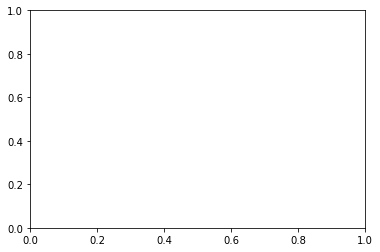

In [17]:
plt.plot(slpsa[:len(a)],a['slp_ave']/1000,'.')
plt.plot(np.arange(1e-2,1.0,1e-2),np.arange(1e-2,1.0,1e-2),'.')
plt.yscale('log')
plt.xscale('log')

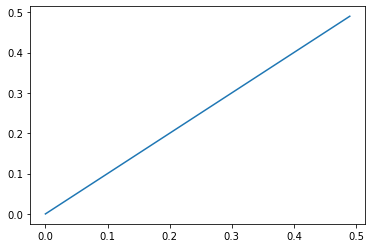

In [135]:
plt.plot(np.arange(0,.5,.01),np.arange(0,.5,.01))

In [8]:
np.a['slps1'] = slps1[:len(a)]

In [9]:
np.from sklearn import linear_model

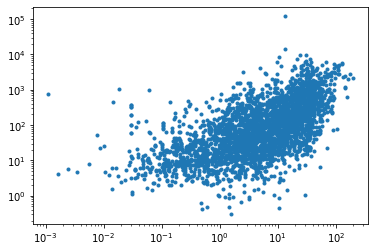

In [63]:
plt.plot(dfs[0][:len(a)], a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [ ]:
eros1[1:]*=1000000

## Begin other thing

In [223]:
#@jit(nopython=True)
#def loop_results(eros1, dfs,n,c):
n = 35#3553
nt = 1000
dfs = np.array([None]*len(eros1[1]))
              
c=0
for i in range(len(eros1[1])):
        dfs[i] = np.zeros(len(eros1))
        for k in range(1,len(eros1)):
            if (eros1[k] is None):
                continue
            else:
                dfs[i][k] = eros1[k][i]
            c+=1
    #return dfs
            

In [154]:
from sklearn import linear_model as lm
import sklearn
r2s = np.zeros(len(eros1[1]))
resid = np.zeros(len(eros1[1]))
pcoef = np.zeros(len(eros1[1]))
ks2 = ks.copy()
diffus2 = diffus.copy()
for i in range(len(eros1[1])):#range(len(ms)):
        if dfs[i] is None:
            continue
        
        y = np.log(np.float64(a['ebe_mmkyr'])/1000)
        x = np.log(dfs[i][:len(a)])
        #I_min = np.where(a['slp_ave'][:n]/1000>1e-1)[0]
        #x=x[I_min]
        #y=y[I_min]
        xi = x.copy()
        I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
        x=np.delete(x,I)
        y=np.delete(y,I)
        I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
        x = np.delete(x,I2)
        y = np.delete(y,I2)
        l1  = lm.LinearRegression(fit_intercept=False)
        l = lm.LinearRegression()
        if len(x[np.logical_not(np.isnan(x))])>n-500:
                print(len(x[np.logical_not(np.isnan(x))]))
                p1 = l1.fit(np.exp(x.reshape(-1,1)),np.exp(y.reshape(-1,1)))
                p = l.fit(x.reshape(-1,1), y.reshape(-1,1 ))

                y2 = p.predict(x.reshape(-1,1))
                y3 = x * p.coef_
                r2s[i] = sklearn.metrics.r2_score(y.reshape(-1,1),y2)
                diffus2[i] *= p1.coef_
                ks2[i] *= p1.coef_
                resid[i] = np.mean(np.power(y-y3,2))
                print(len(y[np.logical_not(np.isnan(x))]))
                pcoef[i] = p.coef_


NameError: name 'dfs' is not defined

Text(0, 0.5, 'r2')

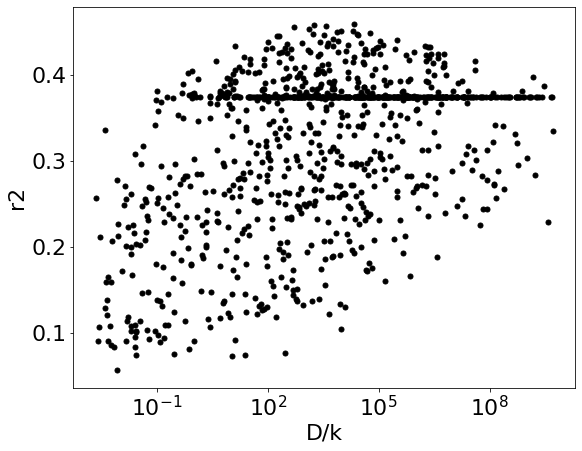

In [277]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.plot((diffus/ks),r2s,'k.', markersize=10)
plt.xscale('log')
plt.xlabel('D/k')
plt.ylabel('r2')


Text(0, 0.5, 'r2')

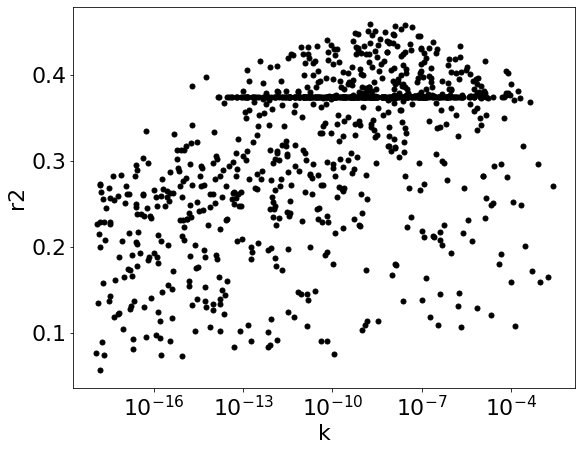

In [285]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.plot((ks2),r2s,'k.', markersize=10)
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('r2')


Text(0, 0.5, 'run count')

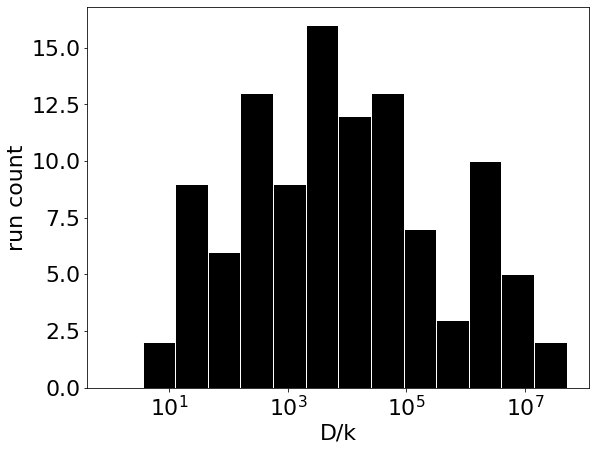

In [289]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.hist(np.divide(diffus[r2s>.4],ks[r2s>.4]),edgecolor='w',color='k',bins = np.power(10.0,np.arange(0,8,.55)))
plt.xscale('log')
plt.xlabel('D/k')
plt.ylabel('run count')

In [259]:
np.power(10,np.arange(-10,-4))

ValueError: Integers to negative integer powers are not allowed.

Text(0, 0.5, 'run count')

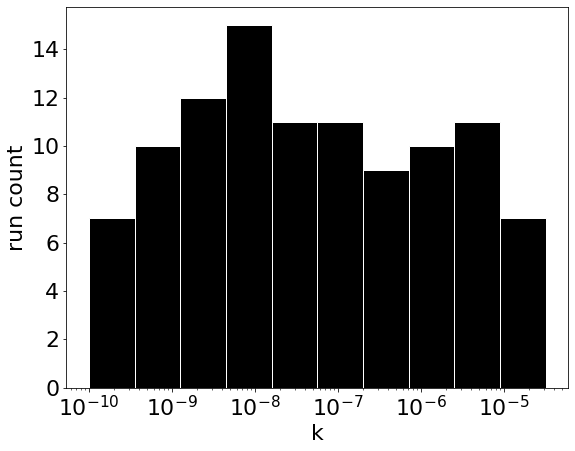

In [270]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.hist((ks[r2s>.4]),edgecolor='w',color='k',bins = np.power(10.0,np.arange(-10,-4,.55)))
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('run count')

Text(0, 0.5, 'r2')

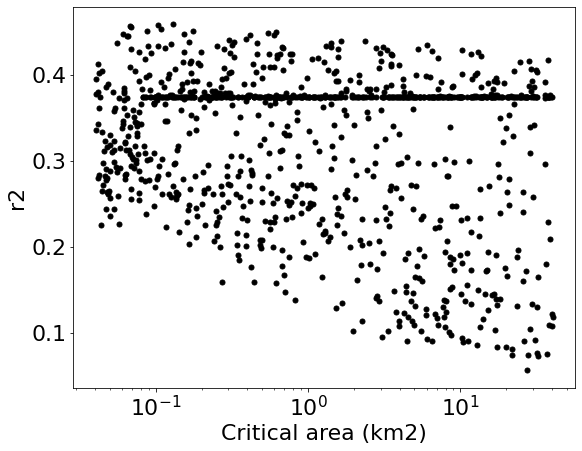

In [293]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.plot((careas)*90**2/1e6,r2s,'k.', markersize=10)
plt.xscale('log')
plt.xlabel('Critical area (km2)')
plt.ylabel('r2')


Text(0, 0.5, 'run count')

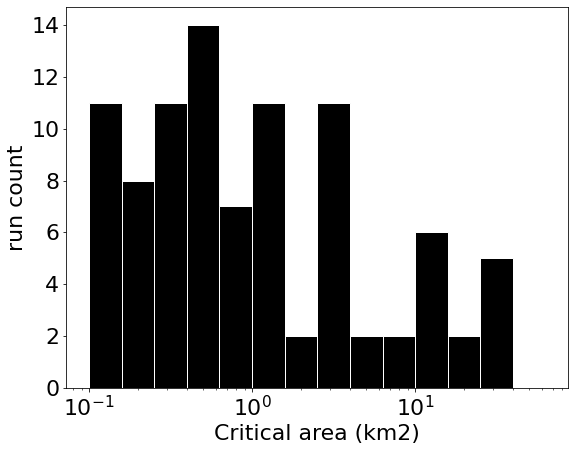

In [304]:
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (9,7))
plt.hist(careas[r2s>.4]*90**2/1e6,edgecolor='w',color='k',bins = np.power(10.0,np.arange(-1,2,.2)))
plt.xscale('log')
plt.xlabel('Critical area (km2)')
plt.ylabel('run count')

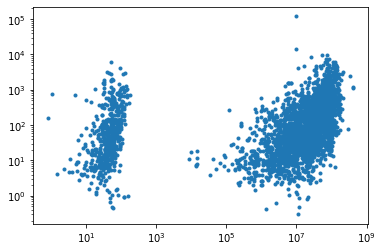

In [122]:
#plt.hist(plt.plot(diffus[r2s>.4]))
#plt.plot(dfs[np.argmax(r2s)][:len(a)],a['ebe_mmkyr'],'.')


In [15]:
ks

array([1.35171591e-05, 2.47521956e-04, 8.90428269e-08, 4.44249167e-06,
       3.04726137e-03, 1.07334156e-04, 1.22966890e-05, 7.73824977e-05,
       2.22489836e-09, 3.70245556e-03, 7.16858240e-07, 5.63449033e-08])

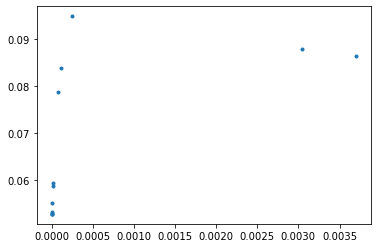

In [14]:
plt.plot(ks,r2s,'.')
#plt.xscale('log')
#plt.yscale('log')

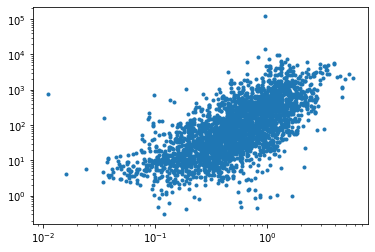

In [33]:
plt.plot(dfs[966][:len(a)],a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [13]:
Gs

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
np.argmin(np.abs(ns-1.9286))

126

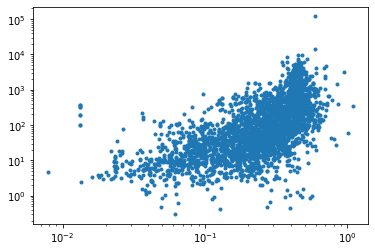

In [54]:
plt.plot(slpsall[:len(a)],a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')
#plt.plot(np.log(dfs[np.argmax(a)]))

In [52]:
diffus[np.argmax(r2s)]

3.804728305633972e-05

In [ ]:
# from sklearn import linear_model as lm
# import sklearn
# r2s = np.zeros((len(ms),len(ns)))
# for i in range(20):#range(len(ms)):
#     for j in range(16):#range(len(ns)):
#         if dfs[i,j] is None:
#             continue
    
#         y = np.log(np.float64(a['ebe_mmkyr'])/1000)
#         x = np.log(dfs[i,j])
#         I_min = np.where(a['slp_ave'][:n]/1000>1e-1)[0]
#         x=x[I_min]
#         y=y[I_min]
#         xi = x.copy()
#         I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
#         x=np.delete(x,I)
#         y=np.delete(y,I)
#         I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
#         x = np.delete(x,I2)
#         y = np.delete(y,I2)
#         l  = lm.LinearRegression()
#         if (len(x)==0) or (len(y)==0):
#             continue
#         p = l.fit(x.reshape(-1,1),y.reshape(-1,1))
#         y2 = p.predict(x.reshape(-1,1))
#         r2s[i,j]=sklearn.metrics.r2_score(y.reshape(-1,1),y2)


(array([228.,  16.,  13.,  16.,  14.,   7.,   3.,   3.,   4.,   4.]),
 array([1.13918299e-07, 9.13308192e-02, 1.82661524e-01, 2.73992230e-01,
        3.65322935e-01, 4.56653640e-01, 5.47984346e-01, 6.39315051e-01,
        7.30645756e-01, 8.21976461e-01, 9.13307167e-01]),
 <BarContainer object of 10 artists>)

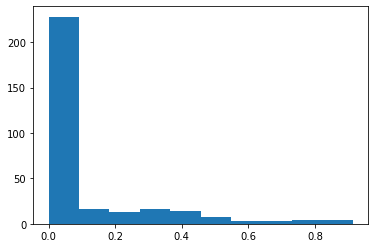

In [84]:
plt.hist(diffus[np.logical_and(r2s<.38,r2s>.36)])

In [15]:
a['ksn'] = a['ebe_mmkyr'].to_numpy()/dfs[4,5][:len(a)]
a.to_file('octo_327_data/')
plt.plot(a['ksn'],a['ebe_mmkyr'],'.')
plt.yscale('log')
plt.xscale('log')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [73]:
plt.plot(dfs[4,10],a['ebe_mmkyr'],'.')
plt.yscale('log')
plt.xscale('log')
plt.xlim([10e-11,10e-5])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

0.31561967388953904

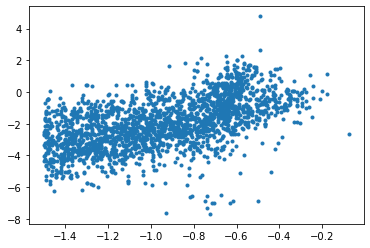

In [13]:
y = np.log(np.float64(a['ebe_mmkyr'])/1000)
x = np.log(np.float64(a['slp_ave'][:n]/1000))
I0 = np.where(x<-1.5)[0]
xi = x.copy()
x = np.delete(x,I0)
y = np.delete(y,I0)
I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
x=np.delete(x,I)
y=np.delete(y,I)
I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
x = np.delete(x,I2)
y = np.delete(y,I2)
l  = lm.LinearRegression()
p = l.fit(x.reshape(-1,1),y.reshape(-1,1))
y2 = p.predict(x.reshape(-1,1))
plt.plot(x,y,'.')
sklearn.metrics.r2_score(y.reshape(-1,1),y2)


ValueError: x and y must have same first dimension, but have shapes (19, 41) and (3553,)

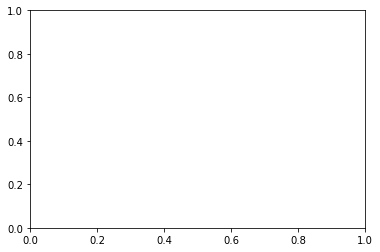

In [72]:
plt.plot(slps1,a['ebe_mmkyr'],'.')
plt.xscale('log')
plt.yscale('log')

In [ ]:
y = np.log(np.float64(a['ebe_mmkyr'])/1000)
x = np.log(np.float64(a['slps1']))
xi = x.copy()
I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
x=np.delete(x,I)
y=np.delete(y,I)
I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
x = np.delete(x,I2)
y = np.delete(y,I2)
l  = lm.LinearRegression()
p = l.fit(x.reshape(-1,1),y.reshape(-1,1))
y2 = p.predict(x.reshape(-1,1))
sklearn.metrics.r2_score(y.reshape(-1,1),y2)

In [15]:
#ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
slps_ = slps1
slps_[slps_<1e-6] = np.nan
ax=plt.plot(eros1[len(a)],a['ebe_gcmyr'][/1000,'.')
plt.yscale('log')
plt.xscale('log')
#plt.xlim([1e-2, 1])
#plt.ylim([1e-2, 1])

#a['ebe_gcmyr'][a['erorate_est']<=0] = np.nan

SyntaxError: invalid syntax (<ipython-input-15-e6381bda8298>, line 4)

In [20]:
r2s

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [ ]:
from sklearn import linear_model as lm
ax=plt.plot(slps1[1:3500],np.float64(a['ebe_mmkyr'][1:3500])/1000,'.')
erate = np.float64(a['ebe_mmkyr'][1:n])/1000
slps1 = slps1[1:n]
I = np.where(slps1 ==0)
np.delete(slps1,I)
slps1 = erate = np.delete(erate,I)
I2 = np.where(np.isnan(erate))
slps1 = np.delete(slps1,I2)
erate = np.delete(erate,I2)
l  = lm.LinearRegression()
l.fit(slps1.reshape(-1,1),erate.reshape(-1,1))
plt.yscale('log')
plt.xscale('log')

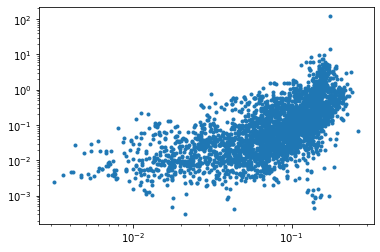

In [47]:
ax=plt.plot(np.float64(a['slp_ave'][1:3500]/3500),np.float64(a['ebe_mmkyr'][1:3500])/1000,'.')
plt.yscale('log')
plt.xscale('log')

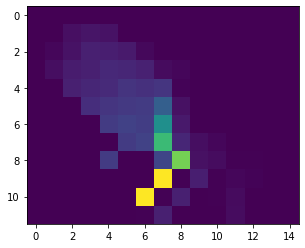

In [109]:
plt.imshow(f.A)

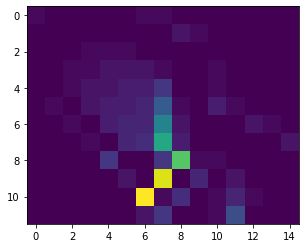

In [114]:
plt.imshow(A)

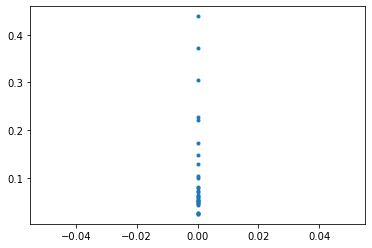

In [40]:
#ax=plt.plot(eros1[:len(a)],a['ebe_gcmyr']/1000,'.')
#ax=plt.plot(slps1[:len(a)],a['slp_ave'],'.')
ax=plt.plot(eros1[:30],np.float64(a['slp_ave'][:30])/1000,'.')

#plt.yscale('log')
#plt.xscale('log')
#plt.xlim([5e-4, 1])

In [119]:
np.argmax(np.abs(slps1[1:30] - np.float64(a['slp_ave'][1:30])))

28

NameError: name 'dfs' is not defined

In [ ]:
import seaborn as sns

In [ ]:
a.columns

Rearrange Section 3 so that it starts with the measurements and then describes how we analyzed them.  Expand it paragraph by paragraph as follows.

3.0.  Measurements of Q and C.  The second paragraph of what is now Section 3.1 is a good start.  Expand the text so that it includes more information about how the measurements were made and where the data are stored so that readers could find the data if they want to.  Paragraphs:
- TWRA measurement history and protocols
- Characteristics of Q and C data (gaps, frequency, etc.)
- We analyzed data from X rivers.  Explain why we chose those rivers.

3.1.  Rating curve background.  Paragraphs:
- What is a rating curve?  Show Equation 1.
- RCs are useful for improving estimates of Q_s
- We used MVUE to estimate a and b.  Explain why we chose this method.
- We centered log(Q) to avoid correlation of a and b
- We applied a correction for log retransformation bias.

3.2.  Rating curve application.  Paragraphs:
- We used the method in Section 3.1 to get daily C and Q_s.  Different rating curves each year.
- We calculated annual Q_s from daily Q_s.  Describe how we dealt with gaps.
- We calculated erosion rates from Q_s.
- How we dealt with nested basins.

3.3.  Landslide volumes generated by Morakot.  Paragraphs:
- We use landslide volumes reported in Marc et al. (2018)
- We calculated basin-total landslide volumes from that inventory.